In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

In [2]:
import prince.config
from prince import core, util, photonfields, cross_sections
from prince import util as pru

CUPY not found for GPU support. Degrading to MKL.


# General Information

This Notebook contains reproductions of results from arXiv:1508.01824  
Specifically these are propagated spectra for different cross sections and photon fields  
**Note:** This notebook contains little documentation, for details see  
`examples/Create_Kernel.ipynb` and `examples/Propagate_single_spectrum.ipynb`

# Setup and save prince_run objects

Setup and save Kernels for different cross sections  
Analogous to `examples/Create_Kernel.ipynb`

In [3]:
%%time
pf = photonfields.CombinedPhotonField(
                [photonfields.CMBPhotonSpectrum, 
                 photonfields.CIBGilmore2D])
cs = cross_sections.CompositeCrossSection([(0., cross_sections.TabulatedCrossSection, ('PEANUT_IAS',)),
                                           (0.14, cross_sections.SophiaSuperposition, ())])
prince_run_peanut = core.PriNCeRun(max_mass = 56, photon_field=pf, cross_sections=cs)

CompositeCrossSection::_join_models(): Attempt to join 2 models.
PriNCeRun::__init__(): initialising Energy grid
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (302, 302)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (301, 301)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (201, 201)
PhotoNuclearInteractionRate::_init_coupling_mat(): Initiating coupling matrix in (CSR) format
CPU times: user 3min 23s, sys: 17.4 s, total: 3min 40s
Wall time: 3min 27s


# Different EBL Models

In [4]:
from prince.cr_sources import RigdityCutoffSource

In [5]:
pf_gilmore = photonfields.CombinedPhotonField(
    [photonfields.CMBPhotonSpectrum,photonfields.CIBGilmore2D])

pf_dominguez = photonfields.CombinedPhotonField(
    [photonfields.CMBPhotonSpectrum,photonfields.CIBDominguez2D])

pf_inoue = photonfields.CombinedPhotonField(
    [photonfields.CMBPhotonSpectrum,photonfields.CIBInoue2D])

pf_franc = photonfields.CombinedPhotonField(
    [photonfields.CMBPhotonSpectrum,photonfields.CIBFranceschini2D])

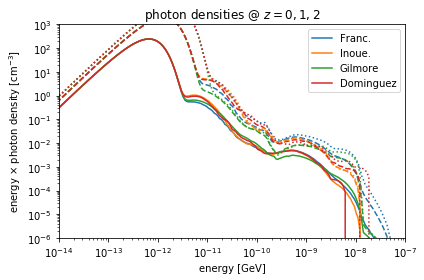

In [6]:
fig, (ax1) = plt.subplots(1, figsize = (6,4))

eplot = np.logspace(-18, -7, 300)

plt.loglog(eplot, eplot * pf_gilmore.get_photon_density(eplot, 0.), label = 'Franc.')
plt.loglog(eplot, eplot * pf_dominguez.get_photon_density(eplot, 0.), label = 'Inoue.')
plt.loglog(eplot, eplot * pf_inoue.get_photon_density(eplot, 0.), label = 'Gilmore')
plt.loglog(eplot, eplot * pf_franc.get_photon_density(eplot, 0.), label = 'Dominguez')

plt.gca().set_prop_cycle(None)
plt.loglog(eplot, eplot * pf_gilmore.get_photon_density(eplot, 1.), ls = 'dashed')
plt.loglog(eplot, eplot * pf_dominguez.get_photon_density(eplot, 1.), ls = 'dashed')
plt.loglog(eplot, eplot * pf_inoue.get_photon_density(eplot, 1.), ls = 'dashed')
plt.loglog(eplot, eplot * pf_franc.get_photon_density(eplot, 1.), ls = 'dashed')

plt.gca().set_prop_cycle(None)
plt.loglog(eplot, eplot * pf_gilmore.get_photon_density(eplot, 2.), ls = 'dotted')
plt.loglog(eplot, eplot * pf_dominguez.get_photon_density(eplot, 2.), ls = 'dotted')
plt.loglog(eplot, eplot * pf_inoue.get_photon_density(eplot, 2.), ls = 'dotted')
plt.loglog(eplot, eplot * pf_franc.get_photon_density(eplot, 2.), ls = 'dotted')

plt.xlim(1e-14,1e-7)
plt.ylim(1e-6,1e3)

plt.title('photon densities @ $z = 0, 1, 2$')
plt.xlabel('energy [GeV]')
plt.ylabel(r'energy $ \times $ photon density [cm$^{-3}$]')
plt.legend()

plt.tight_layout()

### Hard iron

In [7]:
from prince.solvers import UHECRPropagationSolverBDF

In [8]:
prince_run = prince_run_peanut

In [9]:
source_hard_iron = RigdityCutoffSource(prince_run, params={5626:(1.0, 5e9,  1.0)}, norm=1e-87)
source_soft_iron = RigdityCutoffSource(prince_run, params={5626:(2.0, 1e11, 1.0)}, norm=1e-87)
source_hard_nitro = RigdityCutoffSource(prince_run, params={1407:(1.0, 5e9,  1.0)}, norm=1e-87)
source_soft_nitro = RigdityCutoffSource(prince_run, params={1407:(2.0, 1e11, 1.0)}, norm=1e-87)

In [10]:
prince_run.set_photon_field(pf_gilmore)

solver_gilmore = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_gilmore.add_source_class(source_hard_iron)
solver_gilmore.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [11]:
prince_run.set_photon_field(pf_dominguez)

solver_dominguez = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_dominguez.add_source_class(source_hard_iron)
solver_dominguez.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [12]:
prince_run.set_photon_field(pf_franc)

solver_franc = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_franc.add_source_class(source_hard_iron)
solver_franc.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [13]:
prince_run.set_photon_field(pf_inoue)

solver_inoue = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_inoue.add_source_class(source_hard_iron)
solver_inoue.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/

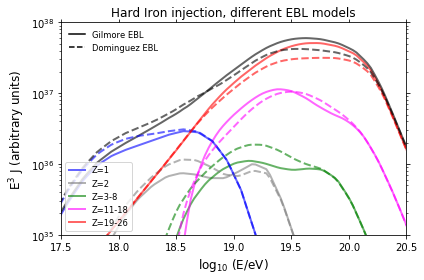

In [14]:
import matplotlib.pyplot as plt

ncoid2sref = solver_gilmore.spec_man.ncoid2sref
Z = lambda el: ncoid2sref[el].Z if el > 100 else 0

# normalize
result = solver_gilmore.res
energy, spectrum = result.get_solution_group('CR')
norm = 6e37/np.max(spectrum[(1e10 < energy) & (energy< 1e11)])
alpha = .6

# plot results
for result, ls in zip([solver_gilmore.res,solver_dominguez.res],['solid','dashed']):
    
    for group, color, label in zip([(Z,1,1),(Z,2,2),(Z,3,10),(Z,11,18),(Z,19,26),'CR'],
                                 ['blue','grey','green','magenta','red','black'],
                                 ['Z=1','Z=2','Z=3-8','Z=11-18','Z=19-26','total']):    
        energy, spectrum = result.get_solution_group(group)
        l = plt.plot(np.log10(1e9*energy), norm* spectrum, ls=ls, lw=2., alpha = alpha, label=label, c=color)

#custom legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

#Create custom artists
legend_gilmore = plt.Line2D((0,1),(0,0), color='k', linestyle='solid')
legend_dominguez = plt.Line2D((0,1),(0,0), color='k', linestyle='dashed')

leg2 =  ax.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display],
                  ncol = 1, loc = 'lower left', fontsize = 'small')
ax.legend([legend_gilmore,legend_dominguez],['Gilmore EBL', 'Dominguez EBL'], 
          frameon=False, fontsize = 'small')
ax.add_artist(leg2)

plt.semilogy()
plt.tick_params(axis='both',top=True,right=True,which='both')
plt.xlim(17.5,20.5)
plt.ylim(1e35,1e38)
# plt.grid()
plt.ylabel('E$^3$ J (arbitrary units)', fontsize = 'large')
plt.xlabel('log$_{10}$ (E/eV)', fontsize = 'large')
plt.title('Hard Iron injection, different EBL models')
plt.tight_layout()

### Soft iron

In [15]:
prince_run.set_photon_field(pf_gilmore)

solver_gilmore = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_gilmore.add_source_class(source_soft_iron)
solver_gilmore.solve(dz=1e-3,verbose=False,full_reset=False)

In [16]:
prince_run.set_photon_field(pf_dominguez)

solver_dominguez = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_dominguez.add_source_class(source_soft_iron)
solver_dominguez.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [17]:
prince_run.set_photon_field(pf_franc)

solver_franc = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_franc.add_source_class(source_soft_iron)
solver_franc.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [18]:
prince_run.set_photon_field(pf_inoue)

solver_inoue = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_inoue.add_source_class(source_soft_iron)
solver_inoue.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/

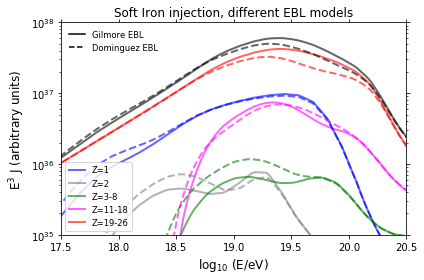

In [19]:
import matplotlib.pyplot as plt

ncoid2sref = solver_gilmore.spec_man.ncoid2sref
Z = lambda el: ncoid2sref[el].Z if el > 100 else 0

# normalize
result = solver_gilmore.res
energy, spectrum = result.get_solution_group('CR')
norm = 6e37/np.max(spectrum[(1e10 < energy) & (energy< 1e11)])
alpha = .6

# plot results
for result, ls in zip([solver_gilmore.res,solver_dominguez.res],['solid','dashed']):
    
    for group, color, label in zip([(Z,1,1),(Z,2,2),(Z,3,10),(Z,11,18),(Z,19,26),'CR'],
                                 ['blue','grey','green','magenta','red','black'],
                                 ['Z=1','Z=2','Z=3-8','Z=11-18','Z=19-26','total']):    
        energy, spectrum = result.get_solution_group(group)
        l = plt.plot(np.log10(1e9*energy), norm* spectrum, ls=ls, lw=2., alpha = alpha, label=label, c=color)

#custom legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

#Create custom artists
legend_gilmore = plt.Line2D((0,1),(0,0), color='k', linestyle='solid')
legend_dominguez = plt.Line2D((0,1),(0,0), color='k', linestyle='dashed')

leg2 =  ax.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display],
                  ncol = 1, loc = 'lower left', fontsize = 'small')
ax.legend([legend_gilmore,legend_dominguez],['Gilmore EBL', 'Dominguez EBL'], 
          frameon=False, fontsize = 'small')
ax.add_artist(leg2)

plt.semilogy()
# plt.legend(ncol=1, loc='upper left')
plt.tick_params(axis='both',top=True,right=True,which='both')
plt.xlim(17.5,20.5)
plt.ylim(1e35,1e38)
# plt.grid()
plt.ylabel('E$^3$ J (arbitrary units)', fontsize = 'large')
plt.xlabel('log$_{10}$ (E/eV)', fontsize = 'large')
plt.title('Soft Iron injection, different EBL models')
plt.tight_layout()